<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Final-Engineering" data-toc-modified-id="1.-Final-Engineering-1">1. Final Engineering</a></span><ul class="toc-item"><li><span><a href="#1.1-Feature-Scaling" data-toc-modified-id="1.1-Feature-Scaling-1.1">1.1 Feature Scaling</a></span></li><li><span><a href="#1.2-SMOTE" data-toc-modified-id="1.2-SMOTE-1.2">1.2 SMOTE</a></span></li><li><span><a href="#1.3-Convert-dataframe" data-toc-modified-id="1.3-Convert-dataframe-1.3">1.3 Convert dataframe</a></span></li></ul></li><li><span><a href="#2.-Model(With-outliers)" data-toc-modified-id="2.-Model(With-outliers)-2">2. Model(With outliers)</a></span><ul class="toc-item"><li><span><a href="#2.1-Define-the-Model" data-toc-modified-id="2.1-Define-the-Model-2.1">2.1 Define the Model</a></span></li><li><span><a href="#2.2-Train-the-model(No-SMOTE)" data-toc-modified-id="2.2-Train-the-model(No-SMOTE)-2.2">2.2 Train the model(No SMOTE)</a></span></li><li><span><a href="#2.3-Train-the-model(SMOTE)" data-toc-modified-id="2.3-Train-the-model(SMOTE)-2.3">2.3 Train the model(SMOTE)</a></span></li></ul></li></ul></div>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
## 1. Final Engineering

In [ ]:
df_train = pd.read_pickle('../Data/part2_df_train_outliers.pkl')
df_test = pd.read_pickle('../Data/part2_df_test_outliers.pkl')

In [ ]:
X_train = df_train.drop(['loan_status'], axis=1)
y_train = df_train.loc[:, 'loan_status']

X_test = df_test.drop(['loan_status'], axis=1)
y_test = df_test['loan_status']

### 1.1 Feature Scaling

In [ ]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### 1.2 SMOTE

In [ ]:
sm = SMOTE(random_state=12, n_jobs = -1, k_neighbors=5, sampling_strategy='auto')
X_train, y_train = sm.fit_resample(X_train, y_train)

### 1.3 Convert dataframe

In [ ]:
# y_train = torch.tensor(y_train.values).flatten()
# y_test = torch.tensor(y_test.values).flatten()
# X_train = torch.tensor(X_train[X_train.columns].values)
# X_test = torch.tensor(X_test[X_test.columns].values)

In [ ]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

## 2. Model(With outliers)

### 2.1 Define the Model

In [ ]:
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 200)
        self.layer2 = nn.Linear(200, 300)
        self.layer3 = nn.Linear(300, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x 

In [ ]:
model =  TabularModel(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model


### 2.2 Train the model(No SMOTE)

In [ ]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

### 2.3 Train the model(SMOTE)

In [ ]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

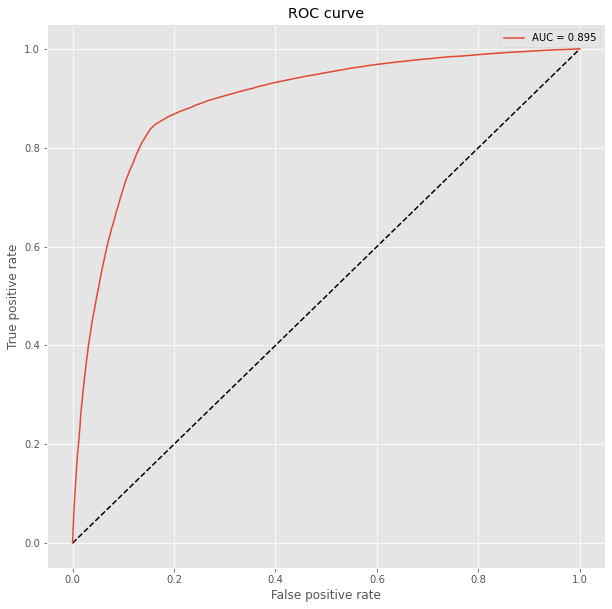

In [13]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

### 2.3 Train the model(SMOTE)

In [9]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [09:11<00:00,  5.51s/it]


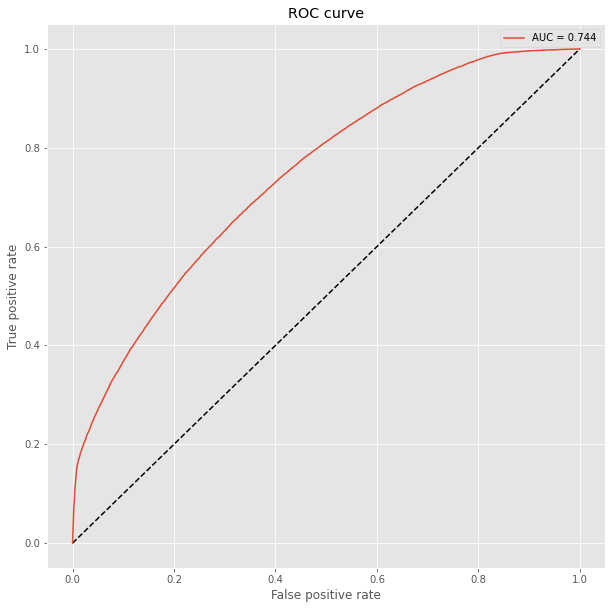

In [10]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();